In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot
from pandas import datetime
from pandas import concat
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [18]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('Data_benjin.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
#dataset.drop('No', axis=1, inplace=True)

In [19]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [20]:
# load data
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
print(dataset.head(30))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-01 00:00:00        NaN  -21 -11.0  1021.0      NW     1.79     0     0
2010-01-01 01:00:00        NaN  -21 -12.0  1020.0      NW     4.92     0     0
2010-01-01 02:00:00        NaN  -21 -11.0  1019.0      NW     6.71     0     0
2010-01-01 03:00:00        NaN  -21 -14.0  1019.0      NW     9.84     0     0
2010-01-01 04:00:00        NaN  -20 -12.0  1018.0      NW    12.97     0     0
2010-01-01 05:00:00        NaN  -19 -10.0  1017.0      NW    16.10     0     0
2010-01-01 06:00:00        NaN  -19  -9.0  1017.0      NW    19.23     0     0
2010-01-01 07:00:00        NaN  -19  -9.0  1017.0      NW    21.02     0     0
2010-01-01 08:00:00        NaN  -19  -9.0  1017.0      NW    24.15     0     0
2010-01-01 09:00:00        NaN  -20  -8.0  1017.0      NW    27.28     0     0
2010-01-01 10:00:00        NaN  -19  -7.0  1017.0   

A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

In [21]:
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [22]:
np.shape(dataset)

(43800, 8)

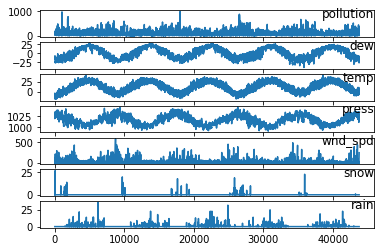

In [23]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [24]:
from sklearn import preprocessing
# load dataset
#dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# wnd_dir column change to categorical
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [25]:
np.shape(scaled)

(43800, 8)

In [27]:
df = pd.DataFrame(scaled)
df.head()

,0,1,2,3,4,5,6,7
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0


In [28]:
# frame as supervised learning
n_in=1 
n_out=1 
dropnan=True

n_vars = scaled.shape[1]
cols, names = list(), list()

# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

# put it all together
reframed = concat(cols, axis=1)
reframed.columns = names

# drop rows with NaN values
reframed.dropna(inplace=True)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.

Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.

In [29]:
np.shape(reframed)

(43799, 9)

In [57]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [48]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
3s - loss: 0.0563 - val_loss: 0.0521
Epoch 2/50
2s - loss: 0.0376 - val_loss: 0.0540
Epoch 3/50
2s - loss: 0.0224 - val_loss: 0.0472
Epoch 4/50
2s - loss: 0.0172 - val_loss: 0.0384
Epoch 5/50
2s - loss: 0.0156 - val_loss: 0.0241
Epoch 6/50
2s - loss: 0.0150 - val_loss: 0.0191
Epoch 7/50
2s - loss: 0.0148 - val_loss: 0.0175
Epoch 8/50
2s - loss: 0.0147 - val_loss: 0.0165
Epoch 9/50
2s - loss: 0.0147 - val_loss: 0.0159
Epoch 10/50
2s - loss: 0.0147 - val_loss: 0.0149
Epoch 11/50
2s - loss: 0.0146 - val_loss: 0.0147
Epoch 12/50
2s - loss: 0.0146 - val_loss: 0.0142
Epoch 13/50
2s - loss: 0.0145 - val_loss: 0.0140
Epoch 14/50
2s - loss: 0.0145 - val_loss: 0.0140
Epoch 15/50
2s - loss: 0.0146 - val_loss: 0.0138
Epoch 16/50
2s - loss: 0.0145 - val_loss: 0.0138
Epoch 17/50
2s - loss: 0.0145 - val_loss: 0.0136
Epoch 18/50
2s - loss: 0.0145 - val_loss: 0.0135
Epoch 19/50
2s - loss: 0.0145 - val_loss: 0.0136
Epoch 20/50
2s - loss: 0.0146

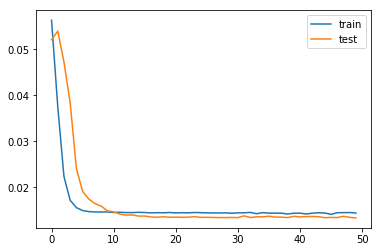

In [49]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
# make a prediction
yhat = model.predict(test_X)

In [58]:
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [62]:
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [64]:
from math import sqrt
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.402
